In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import os
import cv2
from tqdm.notebook import tqdm
from pdb import set_trace
from matplotlib import pyplot as plt
from PIL import Image
import imutils
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import *

In [2]:
def rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """
    angle = math.radians(angle)
    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (bb_w - 2 * x, bb_h - 2 * y)

def crop(img, w, h):
    x, y = int(img.shape[1] * .5), int(img.shape[0] * .5)

    return img[
        int(np.ceil(y - h * .5)) : int(np.floor(y + h * .5)),
        int(np.ceil(x - w * .5)) : int(np.floor(x + h * .5))
    ]

def rotate(img, angle):
    # rotate, crop and return original size
    (h, w) = img.shape[:2]
    img = imutils.rotate_bound(img, angle)
    img = crop(img, *rotated_rect(w, h, angle))
    img = cv2.resize(img,(w,h),interpolation=cv2.INTER_AREA)
    return img


def process_data(save_path = 'processed_train/'):
    '''
    1. Resize image to 320x320
    2. Rotate image to <-30, -15, 0, 15, 30> degrees
    3. Save in proccessed_data
    '''
    _path_to_data = 'train/'
    f_names = os.listdir(_path_to_data)
    rotation_angles = [-30, -15, 0, 15, 30]
    
    for f_name in tqdm(f_names):
        image = np.asarray(Image.open(_path_to_data + f_name))
        
        image = cv2.resize(image, (320, 320))
        
        for i in rotation_angles:
            im = rotate(image, i)
            im = Image.fromarray(im)
            
            # save high quality image
            im.save(save_path + 'hq/' + 'processed_' + f_name)
            
            # save low quality image
            quality = np.random.randint(5, 16)
            im.save(save_path + 'lq/' + 'processed_' + f_name, quality=quality)
    
if input('Sure?') == 'y':
    process_data()

Sure?n


### Denoising Sub-Network (DSN)

In [2]:
class DSN_Encoder(nn.Module):
    def __init__(self):
        super(DSN_Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (32, 32), stride = 2)
        self.pool1 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (64, 64), stride = 2)
        self.pool2 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (128, 128), stride = 2)
        self.pool3 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
        self.conv4 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (256, 256), stride = 2)
        self.pool4 = nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        
        self.conv5 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = (512, 512), stride = 2)
    
    def forward(self, x):
        x = self.conv1(x)
        #x = self.pool1(x)
        print(f'1: {x.shape}')
        
        x = self.conv2(x)
        #x = self.pool2(x)
        print(f'2: {x.shape}')
        
        x = self.conv3(x)
        #x = self.pool3(x)
        print(f'3: {x.shape}')
        
        x = self.conv4(x)
        #x = self.pool4(x)
        print(f'4: {x.shape}')
        
        x = self.conv5(x)
        print(f'5: {x.shape}')
        
        return x

In [3]:
# loading data

lim = 8000

f_names = os.listdir('processed_train/hq')[:lim]
y_train = [None] * len(f_names)

for index, f_name in enumerate(tqdm(f_names)):    
    y_train[index] = np.asarray(Image.open('processed_train/hq/' + f_name).convert('L'))
y_train = np.array(y_train) 


f_names = os.listdir('processed_train/lq')[:lim]
X_train = [None] * len(f_names)

for index, f_name in enumerate(tqdm(f_names)):
    X_train[index] = np.asarray(Image.open('processed_train/lq/' + f_name).convert('L'))
X_train = np.array(X_train)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [4]:
from torch.utils.data import Dataset, DataLoader

class TrainLoader(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data # low quality images
        self.y_data = y_data # high quality images
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    
    def __len__(self):
        return len(self.X_data)

'''
train_data = TrainLoader(
    torch.from_numpy(np.asarray(X_train).transpose((0, 3, 1, 2))).float().div(255),
    torch.from_numpy(np.asarray(y_train).transpose((0, 3, 1, 2))).float().div(255)
)
'''
train_data = TrainLoader(
    torch.from_numpy(np.expand_dims(X_train, axis=1)).float().div(255),
    torch.from_numpy(np.expand_dims(X_train, axis=1)).float().div(255)
)

In [7]:
class DSNTiny(nn.Module):
    def __init__(self):
        super(DSNTiny, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = (7, 7), stride = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (7, 7), stride = 2)
        
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (5, 5))
        
        
        self.conv4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = (5, 5))

        self.conv5 = nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = (7, 7), stride = 2)
        
        self.conv6 = nn.ConvTranspose2d(in_channels = 32, out_channels = 1, kernel_size = (7, 7), stride = 2, output_padding = 1)

        self.leaky_relu = nn.LeakyReLU() 
        
    def forward(self, x):
        
        # encoder
        
        x = self.leaky_relu(self.conv1(x))
        x = self.leaky_relu(self.conv2(x))
        x = self.leaky_relu(self.conv3(x))
        
        # deconder
        
        x = self.leaky_relu(self.conv4(x))
        x = self.leaky_relu(self.conv5(x))
        x = self.leaky_relu(self.conv6(x))
        
        return x
    


def pixel_loss(y_pred, y_true):
    total_diff = 0
    
    #y_pred, y_true = torch.sum(y_pred, dim=1), torch.sum(y_true, dim=1) # sum RGB values into single value for each pixel
    diff = torch.square(y_pred - y_true) # element wise subtraction and then element wise square
    diff = torch.sum(diff, dim=[1, 2]) / (320 * 320) # sum it all up and divide by the number of pixels
    return torch.sum(diff) / y_pred.shape[0] # return average square difference

In [8]:
dsn = DSNTiny()

BATCH_SIZE = 128
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

dsn.train()
EPOCHS = 50
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(dsn.parameters(), lr=LEARNING_RATE)
criterion = pixel_loss
device = 'cuda'
dsn.to(device)

try:
    for e in tqdm(range(1, EPOCHS+1)):
        epoch_loss = 0
        epoch_acc = 0
        epoch_f1 = 0

        for X_batch, y_batch in tqdm(train_loader, leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            y_pred = dsn(X_batch)
            
            loss = pixel_loss(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

except KeyboardInterrupt:
    print('Training has been stopped at epoch: {}'.format(e))

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 001: | Loss: 0.06932


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 002: | Loss: 0.01400


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 003: | Loss: 0.00532


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 004: | Loss: 0.00456


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 005: | Loss: 0.00352


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 006: | Loss: 0.00317


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 007: | Loss: 0.00297


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 008: | Loss: 0.00310


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 009: | Loss: 0.00275


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 010: | Loss: 0.00236


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 011: | Loss: 0.00232


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 012: | Loss: 0.00232


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 013: | Loss: 0.00213


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 014: | Loss: 0.00223


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 015: | Loss: 0.00199


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 016: | Loss: 0.00194


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 017: | Loss: 0.00193


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 018: | Loss: 0.00189


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 019: | Loss: 0.00181


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 020: | Loss: 0.00178


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 021: | Loss: 0.00176


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 022: | Loss: 0.00172


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 023: | Loss: 0.00166


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 024: | Loss: 0.00161


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 025: | Loss: 0.00158


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 026: | Loss: 0.00154


  0%|          | 0/63 [00:00<?, ?it/s]

Training has been stopped at epoch: 27


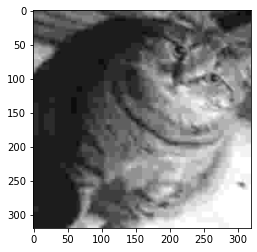

In [27]:
temp3 = X_batch[3].cpu().detach().numpy()
plt.imshow(temp3.transpose((1, 2, 0)), cmap='gray')

In [24]:
X_batch[3].shape

torch.Size([1, 320, 320])

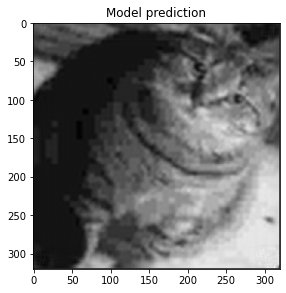

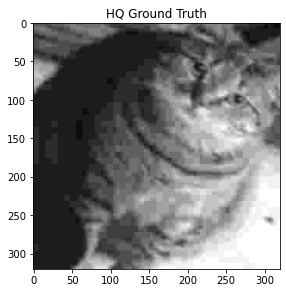

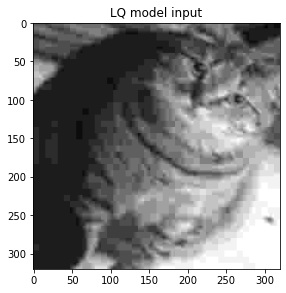

In [35]:
pred = y_pred[3].cpu().detach().numpy()
hq_ground_truth = y_batch[3].cpu().detach().numpy()
lq_model_inp = X_batch[3].cpu().detach().numpy()

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(pred.transpose((1, 2, 0)), cmap='gray')
plt.title('Model prediction')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(132)
plt.imshow(hq_ground_truth.transpose((1, 2, 0)), cmap='gray')
plt.title('HQ Ground Truth')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(133)
plt.imshow(lq_model_inp.transpose((1, 2, 0)), cmap='gray')
plt.title('LQ model input')
plt.show()

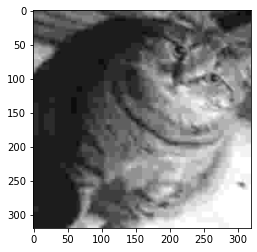

In [10]:
plt.imshow(temp2.transpose((1, 2, 0)), cmap='gray')

### Testing

In [38]:
lim_start = 8000
lim_end = 12648

f_names = os.listdir('processed_train/hq')[lim_start:lim_end]
y_test = [None] * len(f_names)

for index, f_name in enumerate(tqdm(f_names)):    
    y_test[index] = np.asarray(Image.open('processed_train/hq/' + f_name).convert('L'))
y_test = np.array(y_test) 


f_names = os.listdir('processed_train/lq')[lim_start:lim_end]
X_test = [None] * len(f_names)

for index, f_name in enumerate(tqdm(f_names)):
    X_test[index] = np.asarray(Image.open('processed_train/lq/' + f_name).convert('L'))
X_test = np.array(X_test)

  0%|          | 0/4648 [00:00<?, ?it/s]

  0%|          | 0/4648 [00:00<?, ?it/s]

In [43]:
class TestLoader(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
    
    def __len__ (self):
        return len(self.X_data)


test_data = TestLoader(
    torch.from_numpy(np.expand_dims(X_test, axis=1)).float().div(255)
)

y_true = torch.from_numpy(np.expand_dims(y_test, axis=1)).float().div(255)

test_loader = DataLoader(dataset=test_data, batch_size=1)

In [45]:
!pip install prettytable

In [44]:
import prettytable

ModuleNotFoundError: No module named 'prettytable'

In [79]:
def get_preds(
        model,
        data_loader,
    ):
    
    #preds = np.array([None] * len(data_loader))
    preds = []
    model.eval()
    
    with torch.no_grad():
        for index, X_batch in enumerate(tqdm(data_loader)):
            
            X_batch = X_batch.to(device)
            y_pred = model(X_batch) # we get sigmoided output
            
            preds.append(y_pred.cpu().detach().numpy()[0][0])
            
    
    return np.array(preds)

In [80]:
preds = get_preds(dsn, test_loader)

  0%|          | 0/4648 [00:00<?, ?it/s]

In [100]:
def get_loss(pred, true):
    loss = 0
    for pred_image, true_image in tqdm(zip(pred, true), total=len(pred)):
        loss += pixel_loss(torch.Tensor(pred_image)[None][None], true_image[None])
        
    return loss / len(pred)

In [98]:
preds.shape

(4648, 320, 320)

In [104]:
print(f'Test loss = {get_loss(preds, y_true)}')

  0%|          | 0/4648 [00:00<?, ?it/s]

Test loss = 0.001884663593955338


In [152]:
import random

random_f_name = random.choice(os.listdir('processed_train/hq/')[: lim_start])

lq_image = Image.open('processed_train/lq/' + random_f_name).convert('L')
hq_image = Image.open('processed_train/hq/' + random_f_name).convert('L')
pred = dsn(torch.Tensor(np.asarray(lq_image))[None][None].float().div(255).cuda()).cpu().detach().numpy()

In [153]:
lq_image = np.expand_dims(np.array(lq_image), -1)
hq_image = np.expand_dims(np.array(hq_image), -1)
pred = pred.transpose((0, 2, 3, 1))[0]

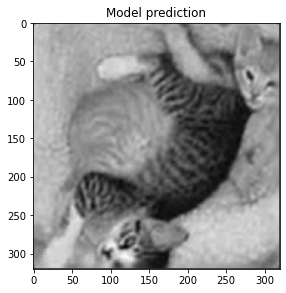

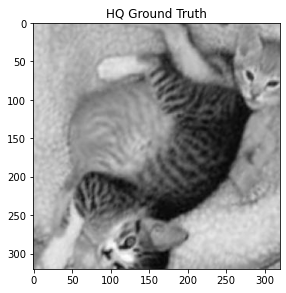

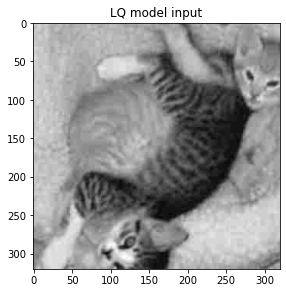

In [154]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(pred, cmap='gray')
plt.title('Model prediction')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(132)
plt.imshow(hq_image, cmap='gray')
plt.title('HQ Ground Truth')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(133)
plt.imshow(lq_image, cmap='gray')
plt.title('LQ model input')
plt.show()

In [159]:
import pickle

with open('saves/train_test.pickle', 'wb') as save_file:
    pickle.dump([X_train, y_train, X_test, y_test], save_file)

In [160]:
torch.save(dsn, 'saves/model.pt')